# Self-supervised Vision Transformer for Land Cover Segmentation
### Pre-trained model with Swin Transformer and Sentinel-1/2, segmentation head trained with Flair1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git

Cloning into 'LandCover_map_Transformers_SSL'...
remote: Enumerating objects: 8528, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 8528 (delta 29), reused 105 (delta 23), pack-reused 8417
Receiving objects: 100% (8528/8528), 418.46 MiB | 24.56 MiB/s, done.
Resolving deltas: 100% (464/464), done.


In [5]:
cd LandCover_map_Transformers_SSL/src

/content/LandCover_map_Transformers_SSL/src


## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

In [7]:
!pip install wandb
!pip install rasterio
!pip install timm
!pip install einops
!pip install diffdist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 832.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for diffdist: filename=diffdist-0.1-py3-none-any.whl size=6534 sha256=7b6b98f480f1c0e93af0a2f133a9c5897452042d82eb26e168cfca262628e33a
  Stored in directory: /root/.cache/pip/wheels/f1/29/f6/5331a14ab74e769799b76eb32460f447c7feb7375a16b07854
Successfully built diffdist


In [65]:
# Import needed packages
import argparse
import json
import os
import random
import numpy as np
import torch
import wandb
import torch.nn.functional as F
from distutils.util import strtobool
from tqdm import tqdm
from torchvision.models import resnet18, resnet50
from utils import *
import rasterio
from pathlib import Path
import numpy as np
from torchvision import transforms
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from Transformer_SSL.models import build_model
import torch.nn as nn
from Transformer_SSL.models.swin_transformer import SwinTransformerDecoder
import matplotlib.pyplot as plt
from metrics import PixelwiseMetrics
from validation_utils import validate_all
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Quick Start
You can specify in the some hyperparameters in train_config (cell below), such as the learning_rate, the batch_size, number of epochs, or if you wish to fine-tune the model or not (with the finetuning argument), etc.

In [125]:
# Data configurations:
data_config = {
    'train_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/train', # path to the training directory,
    'val_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/val', # path to the validation directory,
    'test_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/test', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 13, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [126]:
# Ensure deterministic behavior
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [127]:
class Flair1Dataset_SSL(torch.utils.data.Dataset):
    def __init__(self, folder_path, size = 256, multimodal = False, seed = 42):
        super(Flair1Dataset_SSL, self).__init__()
        self.resize_transform = transforms.Resize((size, size))
        self.resize_transform_l = transforms.Resize((size, size), interpolation=transforms.InterpolationMode.NEAREST)
        self.folder_path = folder_path
        self.img_files = sorted(list(get_data_paths(Path(self.folder_path), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.mask_files = sorted(list(get_data_paths(Path(self.folder_path), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.total = len(self.img_files)
        self.n_classes = len(dict_classes)
        self.multimodal = multimodal
        if multimodal == False:
            self.n_inputs = 3
        else:
            self.n_inputs_rgb = 3
            self.n_inputs_ir_el = 2

    def __len__(self):
        return self.total

    def __getitem__(self, idx):
        img = {}
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        label = rasterio.open(mask_path).read()
        label = label - 1

        data = rasterio.open(img_path).read()
        img['rgb'] = data[0:3,:, :]
        img['rgb'] = np.transpose(img['rgb'], (1, 2, 0))
        img['rgb'] = transforms.ToPILImage()(img['rgb'])
        img['rgb'] = self.resize_transform(img['rgb'])
        # Convert back to tensor
        img['rgb'] = transforms.ToTensor()(img['rgb'])

        img['ir_el'] = data[3:,:, :]
        img['ir_el'] = np.transpose(img['ir_el'], (1, 2, 0))
        img['ir_el'] = transforms.ToPILImage()(img['ir_el'])
        img['ir_el'] = self.resize_transform(img['ir_el'])
        # Convert back to tensor
        img['ir_el'] = transforms.ToTensor()(img['ir_el'])

        # Convert label to PIL Image for resizing
        label = np.transpose(label, (1, 2, 0))
        label = transforms.ToPILImage()(label)
        label = self.resize_transform_l(label)
        #print values uniques in label
        # Convert back to tensor
        label = torch.from_numpy(np.array(label, dtype=np.uint8))
        label = label.long()

        #Turn data and label into float between 0 and 1
        # data = data / 255
        # label = label / 255
        return img, label

    def get_per_per_class(self):
        class_per = dict.fromkeys(range(1,14), 0)
        total_pixels = 0
        for i in range(len(self)):
            _, label = self[i]
            for j in range(1,13):
                class_per[j] += torch.sum(label == j).item()
            total_pixels += label.numel()
        for j in range(1,14):
            class_per[j] = class_per[j] / total_pixels
        return class_per

In [128]:
#from dfc_dataset import DFCDataset
size = 224
multimodal = True
train_dataset = Flair1Dataset_SSL(data_config['train_dir'], size, multimodal)
val_dataset = Flair1Dataset_SSL(data_config['val_dir'], size, multimodal)
test_dataset = Flair1Dataset_SSL(data_config['test_dir'], size, multimodal)

"# Create Training Dataset\ntrain_dataset = DFCDataset(\n    data_config['train_dir'],\n    mode=data_config['train_mode'],\n    clip_sample_values=data_config['clip_sample_values'],\n    used_data_fraction=data_config['train_used_data_fraction'],\n    image_px_size=data_config['image_px_size'],\n    cover_all_parts=data_config['cover_all_parts_train'],\n    seed=data_config['seed'],\n)\n\n# Create Validation Dataset\nval_dataset = DFCDataset(\n    data_config['val_dir'],\n    mode=data_config['val_mode'],\n    clip_sample_values=data_config['clip_sample_values'],\n    used_data_fraction=data_config['val_used_data_fraction'],\n    image_px_size=data_config['image_px_size'],\n    cover_all_parts=data_config['cover_all_parts_validation'],\n    seed=data_config['seed'],\n)"

We can see how many examples are in each split by checking their length:

In [129]:
len(train_dataset), len(val_dataset)

(1664, 416)

In [130]:
#loop on train_ds and check shape of rgb and ir_el
rgb = train_dataset[0][0]['rgb']
ir_el = train_dataset[0][0]['ir_el']
print(rgb.shape)
print(ir_el.shape)

torch.Size([3, 224, 224])
torch.Size([2, 224, 224])


We define a correspondance of label and names:

In [131]:
dict_classes_13 = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'other'}

Our data is now ready to be used by the model. In the next section we load and configure the model.

<a id='quickstart'></a>
## 3. Quick Start

#### Configure

You can specify in the some hyperparameters in `train_config` (cell below), such as the `learning_rate`, the `batch_size`, number of `epochs`, or if you wish to fine-tune the model or not (with the `finetuning` argument), etc.

In [132]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': False, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999),
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 20,
    'target': 'dfc_label'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1e7QhC2-zoBFgb65yN1ADWBZLMShHOweY/view), save it in the `checkpoints/` directory then run the following cell.

Make sure to properly modify the path to the downloaded checkpoint in the path below.

In the case where you are using a uni-modal dataset (Sentinel-2 only or Sentinel-1 only), you can load the corresponding weight stream `s1_weights` or `s2_weights`, and comment the other one.

In [133]:
# path to the checkpoint
checkpoint = torch.load(
    "../../drive/MyDrive/MVA/swin_t.pth",#, map_location=torch.device('cpu') #comment map_location if using GPU
)
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

#### Prepare model and load checkpoint

We prepare the model by specifying the `input_channels`: only sentinel1, only sentinel2 or both. We also specify if we need both backbones `s1_backbone` and `s2_backbone` depending on our application. In the case where only one stream is needed, just comment the lines `s1_backbone` or `s2_backbone`.

In [134]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def dotdictify(d):
    """recursively wrap a dictionary and
    all the dictionaries that it contains
    with the dotdict class
    """
    d = dotdict(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = dotdictify(v)
    return d

In [135]:
#from utils_SSL import save_checkpoint_single_model, dotdictify

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

# Input channel size
# input_channels = 3#train_config['s1_input_channels'] + train_config['s2_input_channels']

# If you are using a uni-modal dataset, you can un-comment one of these lines, and comment the one above:
# input_channels = train_config['s1_input_channels']
# input_channels = train_config['s2_input_channels']

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

<All keys matched successfully>

We create the downstream model head that will be trained. In this demo, we will train a classifier. You can find a segmentation head in the repository (/TransformerSSL/models/swin_transformer/DoubleSwinTransformerSegmentation). Our classifier takes as input the pre-trained backbone (in the form of two streams `encoder1` and `encoder2`), the `out_dim` (number of classes), and `freeze_layers` flag, specifying whether you wish to freeze the backbone weights or not.

In [136]:
class DoubleSwinTransformerSegmentation(nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=False):
        super(DoubleSwinTransformerSegmentation, self).__init__()

        self.device = device

        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

        self.expand_channels = torch.nn.Conv2d(3, 13, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        expanded_rgb = self.expand_channels(x["rgb"].to(self.device))
        _, x2, x_seg2 = self.backbone2.forward_features(expanded_rgb)

        _, x1, x_seg1 = self.backbone1.forward_features(x["ir_el"].to(self.device))

        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        x2 = self.decoder2.forward_up_features(x2, x_seg2)

        x = torch.cat([x1, x2], dim=-1)

        output = self.decoder1.up_x4(x)

        return output

In [137]:
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device
    )

model = model.to(device)

Define and initialise the loss for training. Here we are training for single-class classification and using a `torch.nn.CrossEntropyLoss` loss.

In [138]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Define the trainable parameters (needed for the optimizer):

In [139]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Frozen backbone


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want.

In [140]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader

In [141]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Everything is set and we are now ready to train the segmentation head:

Epoch:0, Training Loss:2.271: 100%|██████████| 104/104 [05:00<00:00,  2.89s/it]


{'train_loss': 2.2857768535614014, 'train_average_accuracy': 0.09757711975563163, 'train_mIoU': 0.05196175281896828, 'train_accuracy_pixelclass_0': 0.010105386278941026, 'train_accuracy_pixelclass_1': 0.013675079444485438, 'train_accuracy_pixelclass_2': 0.03513907093094926, 'train_accuracy_pixelclass_3': 0.008048923818072623, 'train_accuracy_pixelclass_4': 0.014842444605740008, 'train_accuracy_pixelclass_5': 0.021925479651456643, 'train_accuracy_pixelclass_6': 0.28249911268712835, 'train_accuracy_pixelclass_7': 0.03097990556143217, 'train_accuracy_pixelclass_8': 0.04722418665858442, 'train_accuracy_pixelclass_9': 0.747034488737236, 'train_accuracy_pixelclass_10': 0.03470025652771606, 'train_accuracy_pixelclass_11': 0.0028283376679886867, 'train_accuracy_pixelclass_12': 0.01949988425348034, 'train_IoU_class_0': 0.008730900187975621, 'train_IoU_class_1': 0.010931729541608358, 'train_IoU_class_2': 0.026739566043352446, 'train_IoU_class_3': 0.003888811928019539, 'train_IoU_class_4': 0.0106

Validation Loss:2.057: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]


Epoch:0 {'validation_loss': 2.0570240020751953, 'validation_average_accuracy': 0.11965528185053748, 'validation_mIoU': 0.059062943609428056, 'validation_accuracy_pixelclass_0': 0.00024438593993155177, 'validation_accuracy_pixelclass_1': 0.0005967899625224051, 'validation_accuracy_pixelclass_2': 0.0024325827078120654, 'validation_accuracy_pixelclass_3': 8.344354835345018e-06, 'validation_accuracy_pixelclass_4': 0.006989739371541334, 'validation_accuracy_pixelclass_5': 0.005439903804464074, 'validation_accuracy_pixelclass_6': 0.5984837267715295, 'validation_accuracy_pixelclass_7': 0.003751539276611587, 'validation_accuracy_pixelclass_8': 0.002227598532681609, 'validation_accuracy_pixelclass_9': 0.9284511367651648, 'validation_accuracy_pixelclass_10': 0.00688852322493178, 'validation_accuracy_pixelclass_11': 4.393344961052997e-06, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.00024365024309649255, 'train_IoU_class_1': 0.0005810857577467359, 'train_IoU_class_2': 0.002329

Epoch:1, Training Loss:1.966: 100%|██████████| 104/104 [04:26<00:00,  2.56s/it]


{'train_loss': 1.9710967540740967, 'train_average_accuracy': 0.13061659644909243, 'train_mIoU': 0.06419042245749843, 'train_accuracy_pixelclass_0': 0.006631003609834687, 'train_accuracy_pixelclass_1': 0.0003741218685063173, 'train_accuracy_pixelclass_2': 0.005992764806759189, 'train_accuracy_pixelclass_3': 1.5498569611179635e-05, 'train_accuracy_pixelclass_4': 0.015535817532502452, 'train_accuracy_pixelclass_5': 0.0005527789511990355, 'train_accuracy_pixelclass_6': 0.7323420511224106, 'train_accuracy_pixelclass_7': 0.0021930993273741755, 'train_accuracy_pixelclass_8': 0.003106256003044085, 'train_accuracy_pixelclass_9': 0.9206014864286693, 'train_accuracy_pixelclass_10': 0.010665338537088379, 'train_accuracy_pixelclass_11': 9.98001999996008e-07, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.006587001348838404, 'train_IoU_class_1': 0.00037253127813504283, 'train_IoU_class_2': 0.005712491345991815, 'train_IoU_class_3': 1.5292312554478862e-05, 'train_IoU_cl

Validation Loss:1.856: 100%|██████████| 26/26 [00:23<00:00,  1.10it/s]


Epoch:1 {'validation_loss': 1.8556004762649536, 'validation_average_accuracy': 0.13806465134946888, 'validation_mIoU': 0.06978605302433272, 'validation_accuracy_pixelclass_0': 0.0173140369426713, 'validation_accuracy_pixelclass_1': 0.000784177937102819, 'validation_accuracy_pixelclass_2': 0.009371471691261993, 'validation_accuracy_pixelclass_3': 4.172177417672509e-06, 'validation_accuracy_pixelclass_4': 0.04552341305240502, 'validation_accuracy_pixelclass_5': 0.0, 'validation_accuracy_pixelclass_6': 0.8144601599430213, 'validation_accuracy_pixelclass_7': 0.004112525076831947, 'validation_accuracy_pixelclass_8': 0.00987965456097721, 'validation_accuracy_pixelclass_9': 0.8884277546248542, 'validation_accuracy_pixelclass_10': 0.004963101536551934, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.017024517489725215, 'train_IoU_class_1': 0.0007811168550815202, 'train_IoU_class_2': 0.008676243612426976, 'train_IoU_class_3': 4.13842193

Epoch:2, Training Loss:1.811: 100%|██████████| 104/104 [04:54<00:00,  2.83s/it]


{'train_loss': 1.8160898685455322, 'train_average_accuracy': 0.14467271520377262, 'train_mIoU': 0.07545372331214296, 'train_accuracy_pixelclass_0': 0.051999491990919335, 'train_accuracy_pixelclass_1': 0.0009784031494833485, 'train_accuracy_pixelclass_2': 0.011890395093425293, 'train_accuracy_pixelclass_3': 5.166189870393212e-06, 'train_accuracy_pixelclass_4': 0.06515573525055138, 'train_accuracy_pixelclass_5': 7.4484170517675624e-06, 'train_accuracy_pixelclass_6': 0.8145722391042292, 'train_accuracy_pixelclass_7': 0.004121706066910882, 'train_accuracy_pixelclass_8': 0.014420545960759052, 'train_accuracy_pixelclass_9': 0.9070214012048499, 'train_accuracy_pixelclass_10': 0.010572765220993884, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.05022213813987593, 'train_IoU_class_1': 0.0009719758906939585, 'train_IoU_class_2': 0.011059081365929934, 'train_IoU_class_3': 5.121481542180522e-06, 'train_IoU_class_4': 0.06341188318976089, 'train_IoU_

Validation Loss:1.756: 100%|██████████| 26/26 [00:22<00:00,  1.18it/s]


Epoch:2 {'validation_loss': 1.7561148405075073, 'validation_average_accuracy': 0.14634933141206383, 'validation_mIoU': 0.08283512508939081, 'validation_accuracy_pixelclass_0': 0.09116302460926021, 'validation_accuracy_pixelclass_1': 0.0010489652924881865, 'validation_accuracy_pixelclass_2': 0.013896217369349742, 'validation_accuracy_pixelclass_3': 0.00012099314511250277, 'validation_accuracy_pixelclass_4': 0.07765304375473867, 'validation_accuracy_pixelclass_5': 1.926993908772254e-06, 'validation_accuracy_pixelclass_6': 0.7442038728929381, 'validation_accuracy_pixelclass_7': 0.0008041165946453522, 'validation_accuracy_pixelclass_8': 0.010397414367336216, 'validation_accuracy_pixelclass_9': 0.9341783331778778, 'validation_accuracy_pixelclass_10': 0.029073400159174423, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.0852747888038405, 'train_IoU_class_1': 0.0010441312726439634, 'train_IoU_class_2': 0.012792004899010143, 'train_IoU

Epoch:3, Training Loss:1.712: 100%|██████████| 104/104 [04:55<00:00,  2.84s/it]


{'train_loss': 1.7144243717193604, 'train_average_accuracy': 0.16748249508711352, 'train_mIoU': 0.09825181587713996, 'train_accuracy_pixelclass_0': 0.19343444352777484, 'train_accuracy_pixelclass_1': 0.0017952434172715684, 'train_accuracy_pixelclass_2': 0.019652496316791324, 'train_accuracy_pixelclass_3': 0.00039521352508508067, 'train_accuracy_pixelclass_4': 0.175718328306194, 'train_accuracy_pixelclass_5': 3.9902234205897655e-05, 'train_accuracy_pixelclass_6': 0.8246059341658659, 'train_accuracy_pixelclass_7': 0.00981762751584219, 'train_accuracy_pixelclass_8': 0.021428618714847022, 'train_accuracy_pixelclass_9': 0.9006463846489424, 'train_accuracy_pixelclass_10': 0.029738243759655593, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.17746524267930944, 'train_IoU_class_1': 0.0017687538822102398, 'train_IoU_class_2': 0.018051626039720815, 'train_IoU_class_3': 0.0003942587677480867, 'train_IoU_class_4': 0.1645428895704443, 'train_IoU_clas

Epoch:4, Training Loss:1.635: 100%|██████████| 104/104 [04:51<00:00,  2.80s/it]


{'train_loss': 1.6335487365722656, 'train_average_accuracy': 0.20135209611707933, 'train_mIoU': 0.12830755103719083, 'train_accuracy_pixelclass_0': 0.36898845252342755, 'train_accuracy_pixelclass_1': 0.003445170499610647, 'train_accuracy_pixelclass_2': 0.04427837449183198, 'train_accuracy_pixelclass_3': 0.0009505789361523509, 'train_accuracy_pixelclass_4': 0.3584578927890807, 'train_accuracy_pixelclass_5': 0.0025149048145503765, 'train_accuracy_pixelclass_6': 0.8371662938458955, 'train_accuracy_pixelclass_7': 0.010006935304287597, 'train_accuracy_pixelclass_8': 0.057367298366078255, 'train_accuracy_pixelclass_9': 0.8679598873124397, 'train_accuracy_pixelclass_10': 0.06643692155947431, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.29991167456614604, 'train_IoU_class_1': 0.0033653446645907684, 'train_IoU_class_2': 0.03944971025091557, 'train_IoU_class_3': 0.0009503371372643202, 'train_IoU_class_4': 0.3212472512728058, '

Validation Loss:1.567: 100%|██████████| 26/26 [00:24<00:00,  1.08it/s]


Epoch:4 {'validation_loss': 1.5673878192901611, 'validation_average_accuracy': 0.19950812054747286, 'validation_mIoU': 0.132309121582687, 'validation_accuracy_pixelclass_0': 0.3175956866891461, 'validation_accuracy_pixelclass_1': 0.004158179892455597, 'validation_accuracy_pixelclass_2': 0.03510531262824841, 'validation_accuracy_pixelclass_3': 0.00026701935473104056, 'validation_accuracy_pixelclass_4': 0.4308344049646458, 'validation_accuracy_pixelclass_5': 0.011297965287131728, 'validation_accuracy_pixelclass_6': 0.787116539431849, 'validation_accuracy_pixelclass_7': 0.02487109264900273, 'validation_accuracy_pixelclass_8': 0.015296489318785241, 'validation_accuracy_pixelclass_9': 0.9337857951674682, 'validation_accuracy_pixelclass_10': 0.033277081733683336, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.26708795613743064, 'train_IoU_class_1': 0.004067069289592665, 'train_IoU_class_2': 0.03180790423142929, 'train_IoU_class_3': 

Epoch:5, Training Loss:1.551: 100%|██████████| 104/104 [04:40<00:00,  2.70s/it]


{'train_loss': 1.5533602237701416, 'train_average_accuracy': 0.23696864293000794, 'train_mIoU': 0.15879656465877234, 'train_accuracy_pixelclass_0': 0.4829225475631183, 'train_accuracy_pixelclass_1': 0.00828370803060037, 'train_accuracy_pixelclass_2': 0.11481352154980286, 'train_accuracy_pixelclass_3': 0.003953426798318405, 'train_accuracy_pixelclass_4': 0.5294667583526935, 'train_accuracy_pixelclass_5': 0.02051666476909375, 'train_accuracy_pixelclass_6': 0.8416815707610668, 'train_accuracy_pixelclass_7': 0.029462213357952318, 'train_accuracy_pixelclass_8': 0.1026659056454591, 'train_accuracy_pixelclass_9': 0.8454891046954344, 'train_accuracy_pixelclass_10': 0.10093355830448028, 'train_accuracy_pixelclass_11': 0.00024451048999902196, 'train_accuracy_pixelclass_12': 0.0001588677720837551, 'train_IoU_class_0': 0.371216001039233, 'train_IoU_class_1': 0.007971166485794948, 'train_IoU_class_2': 0.09667168434477456, 'train_IoU_class_3': 0.003946301422138222, 'train_IoU_class_4': 0.45135239680

Validation Loss:1.538: 100%|██████████| 26/26 [00:23<00:00,  1.13it/s]


Epoch:5 {'validation_loss': 1.5377287864685059, 'validation_average_accuracy': 0.19816150668742338, 'validation_mIoU': 0.13385361777313756, 'validation_accuracy_pixelclass_0': 0.3427482511762336, 'validation_accuracy_pixelclass_1': 0.0022517109336809516, 'validation_accuracy_pixelclass_2': 0.025552283743633677, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.318209493945444, 'validation_accuracy_pixelclass_5': 0.023345531204775862, 'validation_accuracy_pixelclass_6': 0.749879321345552, 'validation_accuracy_pixelclass_7': 0.013547141429564058, 'validation_accuracy_pixelclass_8': 0.0976865577123343, 'validation_accuracy_pixelclass_9': 0.9294478248016574, 'validation_accuracy_pixelclass_10': 0.07343147064362827, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.285633494159023, 'train_IoU_class_1': 0.002223844928305895, 'train_IoU_class_2': 0.023889691194223756, 'train_IoU_class_3': 0.0, 'train_IoU_cla

Epoch:6, Training Loss:1.495: 100%|██████████| 104/104 [04:58<00:00,  2.87s/it]


{'train_loss': 1.4960682392120361, 'train_average_accuracy': 0.2577530714266513, 'train_mIoU': 0.17573339408925695, 'train_accuracy_pixelclass_0': 0.558935966786858, 'train_accuracy_pixelclass_1': 0.011992659268621081, 'train_accuracy_pixelclass_2': 0.23363156743232996, 'train_accuracy_pixelclass_3': 0.0033102361594544503, 'train_accuracy_pixelclass_4': 0.5902551033233852, 'train_accuracy_pixelclass_5': 0.02249421949633804, 'train_accuracy_pixelclass_6': 0.8337195969578908, 'train_accuracy_pixelclass_7': 0.04735170964671219, 'train_accuracy_pixelclass_8': 0.09125404148601768, 'train_accuracy_pixelclass_9': 0.8295267975357651, 'train_accuracy_pixelclass_10': 0.12827164165907157, 'train_accuracy_pixelclass_11': 9.98001999996008e-07, 'train_accuracy_pixelclass_12': 4.5390792023930026e-05, 'train_IoU_class_0': 0.41853526118333423, 'train_IoU_class_1': 0.011506857500772384, 'train_IoU_class_2': 0.18288086228303643, 'train_IoU_class_3': 0.00328121119324452, 'train_IoU_class_4': 0.49009539858

Validation Loss:1.433: 100%|██████████| 26/26 [00:23<00:00,  1.13it/s]


Epoch:6 {'validation_loss': 1.432758092880249, 'validation_average_accuracy': 0.3044824680701044, 'validation_mIoU': 0.20549218335145245, 'validation_accuracy_pixelclass_0': 0.663424008595922, 'validation_accuracy_pixelclass_1': 0.04014583672804302, 'validation_accuracy_pixelclass_2': 0.5697089789488217, 'validation_accuracy_pixelclass_3': 0.0008260911286991568, 'validation_accuracy_pixelclass_4': 0.6332137482895734, 'validation_accuracy_pixelclass_5': 0.07124289180121901, 'validation_accuracy_pixelclass_6': 0.8559900337900233, 'validation_accuracy_pixelclass_7': 0.07037188320036897, 'validation_accuracy_pixelclass_8': 0.20109016877914232, 'validation_accuracy_pixelclass_9': 0.7679883125757087, 'validation_accuracy_pixelclass_10': 0.08391427013198953, 'validation_accuracy_pixelclass_11': 0.0003558609418452927, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.41052952582826485, 'train_IoU_class_1': 0.036597559605652474, 'train_IoU_class_2': 0.3397971462177755, 'train_IoU

Epoch:7, Training Loss:1.426: 100%|██████████| 104/104 [04:34<00:00,  2.64s/it]


{'train_loss': 1.4266130924224854, 'train_average_accuracy': 0.2981602020158483, 'train_mIoU': 0.2070794381450357, 'train_accuracy_pixelclass_0': 0.62918512168405, 'train_accuracy_pixelclass_1': 0.017222242154328205, 'train_accuracy_pixelclass_2': 0.4513534246238193, 'train_accuracy_pixelclass_3': 0.004070957617869851, 'train_accuracy_pixelclass_4': 0.6549316189191846, 'train_accuracy_pixelclass_5': 0.07492043494499344, 'train_accuracy_pixelclass_6': 0.8378590658011611, 'train_accuracy_pixelclass_7': 0.07827024718572888, 'train_accuracy_pixelclass_8': 0.21037199372877077, 'train_accuracy_pixelclass_9': 0.7921578382241546, 'train_accuracy_pixelclass_10': 0.12531842833756382, 'train_accuracy_pixelclass_11': 0.0004121748259983513, 'train_accuracy_pixelclass_12': 9.078158404786004e-06, 'train_IoU_class_0': 0.45235155076433686, 'train_IoU_class_1': 0.016364641362550864, 'train_IoU_class_2': 0.31724115332354064, 'train_IoU_class_3': 0.004013083262565394, 'train_IoU_class_4': 0.52610707238019

Validation Loss:1.363: 100%|██████████| 26/26 [00:23<00:00,  1.11it/s]


Epoch:7 {'validation_loss': 1.3633946180343628, 'validation_average_accuracy': 0.30948828148808716, 'validation_mIoU': 0.2210559046345396, 'validation_accuracy_pixelclass_0': 0.5266335230858875, 'validation_accuracy_pixelclass_1': 0.02792080821248167, 'validation_accuracy_pixelclass_2': 0.5841319013009708, 'validation_accuracy_pixelclass_3': 0.001435229031679343, 'validation_accuracy_pixelclass_4': 0.7061812209002218, 'validation_accuracy_pixelclass_5': 0.1267923452093968, 'validation_accuracy_pixelclass_6': 0.8240232132376828, 'validation_accuracy_pixelclass_7': 0.14397229076012003, 'validation_accuracy_pixelclass_8': 0.14994863447447673, 'validation_accuracy_pixelclass_9': 0.862423630545169, 'validation_accuracy_pixelclass_10': 0.06988486258704706, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.39530957800907973, 'train_IoU_class_1': 0.026331813894699636, 'train_IoU_class_2': 0.40947235847805913, 'train_IoU_class_3': 0.00143

Epoch:8, Training Loss:1.36: 100%|██████████| 104/104 [04:58<00:00,  2.87s/it]


{'train_loss': 1.3593450784683228, 'train_average_accuracy': 0.3237634305318164, 'train_mIoU': 0.22930890125758113, 'train_accuracy_pixelclass_0': 0.6349386317861077, 'train_accuracy_pixelclass_1': 0.01947825568950683, 'train_accuracy_pixelclass_2': 0.6169470078241043, 'train_accuracy_pixelclass_3': 0.008786397422071254, 'train_accuracy_pixelclass_4': 0.6847106973855163, 'train_accuracy_pixelclass_5': 0.12977430232273565, 'train_accuracy_pixelclass_6': 0.8488798383069919, 'train_accuracy_pixelclass_7': 0.0974063038596359, 'train_accuracy_pixelclass_8': 0.2524716639049426, 'train_accuracy_pixelclass_9': 0.7942652437691035, 'train_accuracy_pixelclass_10': 0.12031116672890112, 'train_accuracy_pixelclass_11': 0.0009550879139961796, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.47325705515278504, 'train_IoU_class_1': 0.018401965332114523, 'train_IoU_class_2': 0.41460919470216245, 'train_IoU_class_3': 0.00878011509784866, 'train_IoU_class_4': 0.5544047778545002, 'train_IoU_clas

Validation Loss:1.312: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


Epoch:8 {'validation_loss': 1.311523199081421, 'validation_average_accuracy': 0.35645105843770797, 'validation_mIoU': 0.2516005831410229, 'validation_accuracy_pixelclass_0': 0.6082705453340967, 'validation_accuracy_pixelclass_1': 0.015284340883167671, 'validation_accuracy_pixelclass_2': 0.797294230452815, 'validation_accuracy_pixelclass_3': 0.005373764513962192, 'validation_accuracy_pixelclass_4': 0.7670846350596574, 'validation_accuracy_pixelclass_5': 0.29067546917484194, 'validation_accuracy_pixelclass_6': 0.8283947955218984, 'validation_accuracy_pixelclass_7': 0.10798524706049037, 'validation_accuracy_pixelclass_8': 0.3120666766739532, 'validation_accuracy_pixelclass_9': 0.7940791778333907, 'validation_accuracy_pixelclass_10': 0.10735487718193039, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.4332313906686499, 'train_IoU_class_1': 0.014870757776480859, 'train_IoU_class_2': 0.47531582613136913, 'train_IoU_class_3': 0.005371

Epoch:9, Training Loss:1.304: 100%|██████████| 104/104 [04:50<00:00,  2.79s/it]


{'train_loss': 1.3086694478988647, 'train_average_accuracy': 0.345679715264188, 'train_mIoU': 0.24794205887524606, 'train_accuracy_pixelclass_0': 0.667474513768224, 'train_accuracy_pixelclass_1': 0.02503051304563858, 'train_accuracy_pixelclass_2': 0.7336799038147405, 'train_accuracy_pixelclass_3': 0.017416517600563116, 'train_accuracy_pixelclass_4': 0.6857760542275543, 'train_accuracy_pixelclass_5': 0.24351163070322634, 'train_accuracy_pixelclass_6': 0.8540510250133456, 'train_accuracy_pixelclass_7': 0.12127379917404384, 'train_accuracy_pixelclass_8': 0.24451173898239031, 'train_accuracy_pixelclass_9': 0.78236047630587, 'train_accuracy_pixelclass_10': 0.11856701073082482, 'train_accuracy_pixelclass_11': 0.0001377242759994491, 'train_accuracy_pixelclass_12': 4.5390792023930026e-05, 'train_IoU_class_0': 0.4964748683194098, 'train_IoU_class_1': 0.02380238152560288, 'train_IoU_class_2': 0.4786085493553592, 'train_IoU_class_3': 0.017397508227853818, 'train_IoU_class_4': 0.5517056178780056, 

Validation Loss:1.279: 100%|██████████| 26/26 [00:22<00:00,  1.13it/s]


Epoch:9 {'validation_loss': 1.2786604166030884, 'validation_average_accuracy': 0.38190943487089896, 'validation_mIoU': 0.27283750319213235, 'validation_accuracy_pixelclass_0': 0.5320211222161967, 'validation_accuracy_pixelclass_1': 0.04538455271305198, 'validation_accuracy_pixelclass_2': 0.7571927853710292, 'validation_accuracy_pixelclass_3': 0.010885210882707577, 'validation_accuracy_pixelclass_4': 0.7375693985863477, 'validation_accuracy_pixelclass_5': 0.24389191105766914, 'validation_accuracy_pixelclass_6': 0.8500080347200935, 'validation_accuracy_pixelclass_7': 0.1821734811842746, 'validation_accuracy_pixelclass_8': 0.6366094296784847, 'validation_accuracy_pixelclass_9': 0.657474583011915, 'validation_accuracy_pixelclass_10': 0.30710896531483683, 'validation_accuracy_pixelclass_11': 0.004503178585079322, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.4210859912957642, 'train_IoU_class_1': 0.042023312546736837, 'train_IoU_class_2': 0.5067692003913681, 'train_IoU_cl

Epoch:10, Training Loss:1.267: 100%|██████████| 104/104 [04:49<00:00,  2.78s/it]


{'train_loss': 1.2686936855316162, 'train_average_accuracy': 0.37368153550768424, 'train_mIoU': 0.2740018172233723, 'train_accuracy_pixelclass_0': 0.6785777384480425, 'train_accuracy_pixelclass_1': 0.035978429098828875, 'train_accuracy_pixelclass_2': 0.7612535321944564, 'train_accuracy_pixelclass_3': 0.02586711268105881, 'train_accuracy_pixelclass_4': 0.6990551481269226, 'train_accuracy_pixelclass_5': 0.32611617189669684, 'train_accuracy_pixelclass_6': 0.8529276590175422, 'train_accuracy_pixelclass_7': 0.18193465382244725, 'train_accuracy_pixelclass_8': 0.35926950598958807, 'train_accuracy_pixelclass_9': 0.7621631252199348, 'train_accuracy_pixelclass_10': 0.16269096100442462, 'train_accuracy_pixelclass_11': 0.012025924099951896, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5156880193203062, 'train_IoU_class_1': 0.034071587386892636, 'train_IoU_class_2': 0.49702653164889454, 'train_IoU_class_3': 0.025831881246606243, 'train_IoU_class_4': 0.5751551868132444, 'train_IoU_cla

Validation Loss:1.253: 100%|██████████| 26/26 [00:24<00:00,  1.06it/s]


Epoch:10 {'validation_loss': 1.2525348663330078, 'validation_average_accuracy': 0.33554003227529516, 'validation_mIoU': 0.24851106182157792, 'validation_accuracy_pixelclass_0': 0.6420523571629821, 'validation_accuracy_pixelclass_1': 0.035428548150562164, 'validation_accuracy_pixelclass_2': 0.7336130448843424, 'validation_accuracy_pixelclass_3': 0.01707672217053358, 'validation_accuracy_pixelclass_4': 0.6270478456027073, 'validation_accuracy_pixelclass_5': 0.02435142202515498, 'validation_accuracy_pixelclass_6': 0.8257264476150457, 'validation_accuracy_pixelclass_7': 0.19604015910505668, 'validation_accuracy_pixelclass_8': 0.25177551154434324, 'validation_accuracy_pixelclass_9': 0.8412112349725847, 'validation_accuracy_pixelclass_10': 0.16768833965560187, 'validation_accuracy_pixelclass_11': 8.786689922105994e-06, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.48005363930287026, 'train_IoU_class_1': 0.03378262896208825, 'train_IoU_class_2': 0.5279465445013352, 'train_I

Epoch:11, Training Loss:1.23: 100%|██████████| 104/104 [04:43<00:00,  2.73s/it]


{'train_loss': 1.2288883924484253, 'train_average_accuracy': 0.38576568202951844, 'train_mIoU': 0.2854573593301608, 'train_accuracy_pixelclass_0': 0.7245878955570202, 'train_accuracy_pixelclass_1': 0.04881613444558998, 'train_accuracy_pixelclass_2': 0.7764529283505721, 'train_accuracy_pixelclass_3': 0.029598393314950306, 'train_accuracy_pixelclass_4': 0.7260066397060532, 'train_accuracy_pixelclass_5': 0.3054127646715195, 'train_accuracy_pixelclass_6': 0.8609137285013687, 'train_accuracy_pixelclass_7': 0.22169395480119541, 'train_accuracy_pixelclass_8': 0.36445489841201584, 'train_accuracy_pixelclass_9': 0.7787526892163185, 'train_accuracy_pixelclass_10': 0.16804474985797468, 'train_accuracy_pixelclass_11': 0.010214550469959142, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.5424250834961342, 'train_IoU_class_1': 0.04549607969358457, 'train_IoU_class_2': 0.516199354156096, 'train_IoU_class_3': 0.0295634180920327, 'train_IoU_class_4': 0.6079626666894054, 't

Validation Loss:1.21: 100%|██████████| 26/26 [00:24<00:00,  1.08it/s]


Epoch:11 {'validation_loss': 1.2099041938781738, 'validation_average_accuracy': 0.4036126232366927, 'validation_mIoU': 0.3024613230529366, 'validation_accuracy_pixelclass_0': 0.6871041982878846, 'validation_accuracy_pixelclass_1': 0.07490936125142578, 'validation_accuracy_pixelclass_2': 0.7417032145079328, 'validation_accuracy_pixelclass_3': 0.009182962496297192, 'validation_accuracy_pixelclass_4': 0.7172232069645094, 'validation_accuracy_pixelclass_5': 0.35425085221305613, 'validation_accuracy_pixelclass_6': 0.8328721393476186, 'validation_accuracy_pixelclass_7': 0.17460709823184783, 'validation_accuracy_pixelclass_8': 0.6178099991556352, 'validation_accuracy_pixelclass_9': 0.7251503235248455, 'validation_accuracy_pixelclass_10': 0.3008686362359688, 'validation_accuracy_pixelclass_11': 0.011282109859984096, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.49122128118251895, 'train_IoU_class_1': 0.06912043993508477, 'train_IoU_class_2': 0.5345884644573569, 'train_IoU_cl

Epoch:12, Training Loss:1.198: 100%|██████████| 104/104 [04:43<00:00,  2.73s/it]


{'train_loss': 1.1960155963897705, 'train_average_accuracy': 0.40765954200776106, 'train_mIoU': 0.3050045125722933, 'train_accuracy_pixelclass_0': 0.7193298479403868, 'train_accuracy_pixelclass_1': 0.06098231585949535, 'train_accuracy_pixelclass_2': 0.7875307752481278, 'train_accuracy_pixelclass_3': 0.04512150232801431, 'train_accuracy_pixelclass_4': 0.7226536931575006, 'train_accuracy_pixelclass_5': 0.4307643033548734, 'train_accuracy_pixelclass_6': 0.8607651807438143, 'train_accuracy_pixelclass_7': 0.22543901911649786, 'train_accuracy_pixelclass_8': 0.4355571328612354, 'train_accuracy_pixelclass_9': 0.7614994492777578, 'train_accuracy_pixelclass_10': 0.22961150549327153, 'train_accuracy_pixelclass_11': 0.020319320719918724, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5395076430382261, 'train_IoU_class_1': 0.05668501241694073, 'train_IoU_class_2': 0.5271220339662293, 'train_IoU_class_3': 0.044991281458224404, 'train_IoU_class_4': 0.6019277437986826, 'train_IoU_class_5'

Validation Loss:1.175: 100%|██████████| 26/26 [00:23<00:00,  1.12it/s]


Epoch:12 {'validation_loss': 1.1754205226898193, 'validation_average_accuracy': 0.43529273868076523, 'validation_mIoU': 0.32157587043072233, 'validation_accuracy_pixelclass_0': 0.7642635045953645, 'validation_accuracy_pixelclass_1': 0.13114306664494052, 'validation_accuracy_pixelclass_2': 0.8257254250045862, 'validation_accuracy_pixelclass_3': 0.014844607252078788, 'validation_accuracy_pixelclass_4': 0.7700633195726863, 'validation_accuracy_pixelclass_5': 0.4420119358002709, 'validation_accuracy_pixelclass_6': 0.8702081734413512, 'validation_accuracy_pixelclass_7': 0.3471846875701812, 'validation_accuracy_pixelclass_8': 0.5851389449192693, 'validation_accuracy_pixelclass_9': 0.7353616286803097, 'validation_accuracy_pixelclass_10': 0.17006614197367872, 'validation_accuracy_pixelclass_11': 0.002794167395229706, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.537427753155995, 'train_IoU_class_1': 0.10778325832342175, 'train_IoU_class_2': 0.5479892500615784, 'train_IoU_cla

Epoch:13, Training Loss:1.181: 100%|██████████| 104/104 [04:41<00:00,  2.71s/it]


{'train_loss': 1.1814627647399902, 'train_average_accuracy': 0.41958236574702046, 'train_mIoU': 0.3136711585821133, 'train_accuracy_pixelclass_0': 0.7329498172037889, 'train_accuracy_pixelclass_1': 0.08842837450366235, 'train_accuracy_pixelclass_2': 0.7808830731668471, 'train_accuracy_pixelclass_3': 0.029639722833913452, 'train_accuracy_pixelclass_4': 0.7451203760951489, 'train_accuracy_pixelclass_5': 0.4564911358516786, 'train_accuracy_pixelclass_6': 0.8544350340712924, 'train_accuracy_pixelclass_7': 0.25162557969902755, 'train_accuracy_pixelclass_8': 0.5376495382207359, 'train_accuracy_pixelclass_9': 0.7471709047455184, 'train_accuracy_pixelclass_10': 0.20275310136176178, 'train_accuracy_pixelclass_11': 0.027424096957890304, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5493215167029651, 'train_IoU_class_1': 0.0782892079323038, 'train_IoU_class_2': 0.5236901144860318, 'train_IoU_class_3': 0.02961214783234794, 'train_IoU_class_4': 0.6266991789236644, 'train_IoU_class_5':

Validation Loss:1.143: 100%|██████████| 26/26 [00:23<00:00,  1.12it/s]


Epoch:13 {'validation_loss': 1.1433860063552856, 'validation_average_accuracy': 0.41960228374206265, 'validation_mIoU': 0.32520063083711526, 'validation_accuracy_pixelclass_0': 0.6535182991546468, 'validation_accuracy_pixelclass_1': 0.11389013361577317, 'validation_accuracy_pixelclass_2': 0.7582031700642448, 'validation_accuracy_pixelclass_3': 0.01834089192808835, 'validation_accuracy_pixelclass_4': 0.7837917855759069, 'validation_accuracy_pixelclass_5': 0.4712463603902548, 'validation_accuracy_pixelclass_6': 0.8305952669973793, 'validation_accuracy_pixelclass_7': 0.33976752213016287, 'validation_accuracy_pixelclass_8': 0.47688023623450826, 'validation_accuracy_pixelclass_9': 0.8051501473080916, 'validation_accuracy_pixelclass_10': 0.20212347841448067, 'validation_accuracy_pixelclass_11': 0.001322396833276952, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5213498389557826, 'train_IoU_class_1': 0.09861770658342042, 'train_IoU_class_2': 0.5469732111794039, 'train_IoU_c

Epoch:14, Training Loss:1.145: 100%|██████████| 104/104 [04:50<00:00,  2.80s/it]


{'train_loss': 1.1447793245315552, 'train_average_accuracy': 0.4349977802419633, 'train_mIoU': 0.32841335339946187, 'train_accuracy_pixelclass_0': 0.7433949857660157, 'train_accuracy_pixelclass_1': 0.0897806738751692, 'train_accuracy_pixelclass_2': 0.7843482652326755, 'train_accuracy_pixelclass_3': 0.04953988621466811, 'train_accuracy_pixelclass_4': 0.7385669041232937, 'train_accuracy_pixelclass_5': 0.49973983743297756, 'train_accuracy_pixelclass_6': 0.8590197234559869, 'train_accuracy_pixelclass_7': 0.27621639226009276, 'train_accuracy_pixelclass_8': 0.5575149549014342, 'train_accuracy_pixelclass_9': 0.7409961932696559, 'train_accuracy_pixelclass_10': 0.27113385499573145, 'train_accuracy_pixelclass_11': 0.044719471617821124, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5575576961596451, 'train_IoU_class_1': 0.0798840173741042, 'train_IoU_class_2': 0.5293138707114424, 'train_IoU_class_3': 0.04916826578577316, 'train_IoU_class_4': 0.62855320704643, 'train_IoU_class_5': 0.

Validation Loss:1.127: 100%|██████████| 26/26 [00:23<00:00,  1.11it/s]


Epoch:14 {'validation_loss': 1.126837968826294, 'validation_average_accuracy': 0.4301130016634636, 'validation_mIoU': 0.33321427125658254, 'validation_accuracy_pixelclass_0': 0.7603573689934834, 'validation_accuracy_pixelclass_1': 0.17294891640866872, 'validation_accuracy_pixelclass_2': 0.7338243888047296, 'validation_accuracy_pixelclass_3': 0.019146122169699145, 'validation_accuracy_pixelclass_4': 0.697583712748744, 'validation_accuracy_pixelclass_5': 0.35529335591770195, 'validation_accuracy_pixelclass_6': 0.86256366608019, 'validation_accuracy_pixelclass_7': 0.2850642313564776, 'validation_accuracy_pixelclass_8': 0.6245103856870784, 'validation_accuracy_pixelclass_9': 0.8100078051869097, 'validation_accuracy_pixelclass_10': 0.19725711529770898, 'validation_accuracy_pixelclass_11': 0.07291195297363554, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5339533313665865, 'train_IoU_class_1': 0.13624836029733275, 'train_IoU_class_2': 0.5575522898920579, 'train_IoU_class_3

Epoch:15, Training Loss:1.102: 100%|██████████| 104/104 [04:47<00:00,  2.76s/it]


{'train_loss': 1.1025696992874146, 'train_average_accuracy': 0.4563323303305377, 'train_mIoU': 0.3495622501723756, 'train_accuracy_pixelclass_0': 0.7751737191334553, 'train_accuracy_pixelclass_1': 0.1285234980349576, 'train_accuracy_pixelclass_2': 0.7917996410210111, 'train_accuracy_pixelclass_3': 0.06086159131563483, 'train_accuracy_pixelclass_4': 0.755632978840193, 'train_accuracy_pixelclass_5': 0.5365956690647022, 'train_accuracy_pixelclass_6': 0.8581572671811926, 'train_accuracy_pixelclass_7': 0.3358305811928544, 'train_accuracy_pixelclass_8': 0.6376327289777246, 'train_accuracy_pixelclass_9': 0.7631210332940661, 'train_accuracy_pixelclass_10': 0.235237202517413, 'train_accuracy_pixelclass_11': 0.05375438372378498, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.583380850075317, 'train_IoU_class_1': 0.11078148169470797, 'train_IoU_class_2': 0.5501251739989287, 'train_IoU_class_3': 0.06078685064956006, 'train_IoU_class_4': 0.6571369509558772, 'train_IoU_class_5': 0.47823

Validation Loss:1.102: 100%|██████████| 26/26 [00:23<00:00,  1.08it/s]


Epoch:15 {'validation_loss': 1.1024706363677979, 'validation_average_accuracy': 0.47263863948180607, 'validation_mIoU': 0.35503024970968716, 'validation_accuracy_pixelclass_0': 0.7025590843404155, 'validation_accuracy_pixelclass_1': 0.1940514502199772, 'validation_accuracy_pixelclass_2': 0.7565124187011474, 'validation_accuracy_pixelclass_3': 0.019776120959767694, 'validation_accuracy_pixelclass_4': 0.7651280229335538, 'validation_accuracy_pixelclass_5': 0.4997292573558175, 'validation_accuracy_pixelclass_6': 0.8160784693810866, 'validation_accuracy_pixelclass_7': 0.47425093562394777, 'validation_accuracy_pixelclass_8': 0.8431393014288528, 'validation_accuracy_pixelclass_9': 0.6955864691054052, 'validation_accuracy_pixelclass_10': 0.36399442749315236, 'validation_accuracy_pixelclass_11': 0.013496355720354807, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5385383525696106, 'train_IoU_class_1': 0.15110503831492064, 'train_IoU_class_2': 0.5654326022287229, 'train_IoU_cl

Epoch:16, Training Loss:1.09: 100%|██████████| 104/104 [04:56<00:00,  2.85s/it]


{'train_loss': 1.0880883932113647, 'train_average_accuracy': 0.4627168044536981, 'train_mIoU': 0.35387280440813246, 'train_accuracy_pixelclass_0': 0.7756333342039134, 'train_accuracy_pixelclass_1': 0.12830665176497294, 'train_accuracy_pixelclass_2': 0.7923440613281607, 'train_accuracy_pixelclass_3': 0.06763963242559072, 'train_accuracy_pixelclass_4': 0.7712827144579552, 'train_accuracy_pixelclass_5': 0.5348942377981628, 'train_accuracy_pixelclass_6': 0.8534050916794148, 'train_accuracy_pixelclass_7': 0.3444265902975721, 'train_accuracy_pixelclass_8': 0.6163232716773753, 'train_accuracy_pixelclass_9': 0.7431230534649589, 'train_accuracy_pixelclass_10': 0.32354373975025547, 'train_accuracy_pixelclass_11': 0.06439607904974241, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5775082993710342, 'train_IoU_class_1': 0.10888838929564885, 'train_IoU_class_2': 0.556505089553571, 'train_IoU_class_3': 0.06729051937472535, 'train_IoU_class_4': 0.6677592855385583, 'train_IoU_class_5': 0.

Validation Loss:1.093: 100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


Epoch:16 {'validation_loss': 1.092644453048706, 'validation_average_accuracy': 0.4843518460952672, 'validation_mIoU': 0.3665677458845869, 'validation_accuracy_pixelclass_0': 0.8207964356007703, 'validation_accuracy_pixelclass_1': 0.23968245885611864, 'validation_accuracy_pixelclass_2': 0.8055791958151067, 'validation_accuracy_pixelclass_3': 0.01915446652453449, 'validation_accuracy_pixelclass_4': 0.815978055050312, 'validation_accuracy_pixelclass_5': 0.48612660735379415, 'validation_accuracy_pixelclass_6': 0.8438656569543896, 'validation_accuracy_pixelclass_7': 0.3914525495846779, 'validation_accuracy_pixelclass_8': 0.6896068074566793, 'validation_accuracy_pixelclass_9': 0.7263902210639178, 'validation_accuracy_pixelclass_10': 0.23097255760025162, 'validation_accuracy_pixelclass_11': 0.22696898737791993, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5401926204475956, 'train_IoU_class_1': 0.1747621190451792, 'train_IoU_class_2': 0.5754355545438642, 'train_IoU_class_3'

Epoch:17, Training Loss:1.06: 100%|██████████| 104/104 [04:50<00:00,  2.79s/it]


{'train_loss': 1.0604026317596436, 'train_average_accuracy': 0.4739002113664114, 'train_mIoU': 0.3655234612427912, 'train_accuracy_pixelclass_0': 0.786006551883244, 'train_accuracy_pixelclass_1': 0.15470977236557168, 'train_accuracy_pixelclass_2': 0.7918887408887102, 'train_accuracy_pixelclass_3': 0.05406676008860015, 'train_accuracy_pixelclass_4': 0.7757907522062083, 'train_accuracy_pixelclass_5': 0.5572219319704149, 'train_accuracy_pixelclass_6': 0.8528856395323375, 'train_accuracy_pixelclass_7': 0.35469371166180835, 'train_accuracy_pixelclass_8': 0.6953998225243281, 'train_accuracy_pixelclass_9': 0.746698117832615, 'train_accuracy_pixelclass_10': 0.32091992968579247, 'train_accuracy_pixelclass_11': 0.07042101712371832, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5936413888916823, 'train_IoU_class_1': 0.12787117486743904, 'train_IoU_class_2': 0.5566882834820103, 'train_IoU_class_3': 0.05397898711065035, 'train_IoU_class_4': 0.6851357719937646, 'train_IoU_class_5': 0.4

Validation Loss:1.06: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]


Epoch:17 {'validation_loss': 1.060232400894165, 'validation_average_accuracy': 0.47571449163821666, 'validation_mIoU': 0.3655337944205169, 'validation_accuracy_pixelclass_0': 0.6789192890186895, 'validation_accuracy_pixelclass_1': 0.19301776112106891, 'validation_accuracy_pixelclass_2': 0.8421610790549192, 'validation_accuracy_pixelclass_3': 0.05732571771882027, 'validation_accuracy_pixelclass_4': 0.7309555347021894, 'validation_accuracy_pixelclass_5': 0.32906311483149403, 'validation_accuracy_pixelclass_6': 0.8588759031956718, 'validation_accuracy_pixelclass_7': 0.4075748235389872, 'validation_accuracy_pixelclass_8': 0.7934542964095732, 'validation_accuracy_pixelclass_9': 0.7323744508797317, 'validation_accuracy_pixelclass_10': 0.24371398888956913, 'validation_accuracy_pixelclass_11': 0.3168524319361032, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5129791646637092, 'train_IoU_class_1': 0.14295163970345875, 'train_IoU_class_2': 0.5572093375369058, 'train_IoU_class_

Epoch:18, Training Loss:1.034: 100%|██████████| 104/104 [04:47<00:00,  2.76s/it]


{'train_loss': 1.031813144683838, 'train_average_accuracy': 0.4879676477683344, 'train_mIoU': 0.3775785668440668, 'train_accuracy_pixelclass_0': 0.7848087361174484, 'train_accuracy_pixelclass_1': 0.16373427779925182, 'train_accuracy_pixelclass_2': 0.7870881157460529, 'train_accuracy_pixelclass_3': 0.08069459422807437, 'train_accuracy_pixelclass_4': 0.7874189884901367, 'train_accuracy_pixelclass_5': 0.5591516040166121, 'train_accuracy_pixelclass_6': 0.856861257747184, 'train_accuracy_pixelclass_7': 0.3984568275065114, 'train_accuracy_pixelclass_8': 0.724833843223299, 'train_accuracy_pixelclass_9': 0.7431077621097806, 'train_accuracy_pixelclass_10': 0.35603738882640074, 'train_accuracy_pixelclass_11': 0.10138602517759446, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5930179238931067, 'train_IoU_class_1': 0.13577677628322857, 'train_IoU_class_2': 0.5619308743365129, 'train_IoU_class_3': 0.08034892154795036, 'train_IoU_class_4': 0.6808233986116381, 'train_IoU_class_5': 0.491

Validation Loss:1.031: 100%|██████████| 26/26 [00:24<00:00,  1.07it/s]


Epoch:18 {'validation_loss': 1.0313575267791748, 'validation_average_accuracy': 0.5101911874004282, 'validation_mIoU': 0.38862289202802486, 'validation_accuracy_pixelclass_0': 0.8346547341696988, 'validation_accuracy_pixelclass_1': 0.2602095893759166, 'validation_accuracy_pixelclass_2': 0.7778784852834656, 'validation_accuracy_pixelclass_3': 0.02038943104016555, 'validation_accuracy_pixelclass_4': 0.8107248089406877, 'validation_accuracy_pixelclass_5': 0.584624901000688, 'validation_accuracy_pixelclass_6': 0.8279149222589529, 'validation_accuracy_pixelclass_7': 0.43579652760297893, 'validation_accuracy_pixelclass_8': 0.800383951439642, 'validation_accuracy_pixelclass_9': 0.6742286947108541, 'validation_accuracy_pixelclass_10': 0.3812629364269688, 'validation_accuracy_pixelclass_11': 0.22441645395554813, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5497688526443922, 'train_IoU_class_1': 0.18216227739028948, 'train_IoU_class_2': 0.5803296706785265, 'train_IoU_class_3'

Epoch:19, Training Loss:1.006: 100%|██████████| 104/104 [05:09<00:00,  2.97s/it]


{'train_loss': 1.0060508251190186, 'train_average_accuracy': 0.5023190672320926, 'train_mIoU': 0.3920351867812786, 'train_accuracy_pixelclass_0': 0.7939836259250553, 'train_accuracy_pixelclass_1': 0.18161157169319028, 'train_accuracy_pixelclass_2': 0.7904674027601554, 'train_accuracy_pixelclass_3': 0.0868320277941015, 'train_accuracy_pixelclass_4': 0.775084014587879, 'train_accuracy_pixelclass_5': 0.5970289328440078, 'train_accuracy_pixelclass_6': 0.8566904743264327, 'train_accuracy_pixelclass_7': 0.3763196592100931, 'train_accuracy_pixelclass_8': 0.7813818349073289, 'train_accuracy_pixelclass_9': 0.7451313570210043, 'train_accuracy_pixelclass_10': 0.40257634029452843, 'train_accuracy_pixelclass_11': 0.14304063265342784, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.602406902374498, 'train_IoU_class_1': 0.1486122384768044, 'train_IoU_class_2': 0.5659718018513142, 'train_IoU_class_3': 0.08658878986141878, 'train_IoU_class_4': 0.6738069926618848, 'train_IoU_class_5': 0.5272

Validation Loss:1.044: 100%|██████████| 26/26 [00:23<00:00,  1.12it/s]


Epoch:19 {'validation_loss': 1.043854832649231, 'validation_average_accuracy': 0.48109765286753253, 'validation_mIoU': 0.36450957780605997, 'validation_accuracy_pixelclass_0': 0.7666649499059316, 'validation_accuracy_pixelclass_1': 0.21008228776275054, 'validation_accuracy_pixelclass_2': 0.7400356305991955, 'validation_accuracy_pixelclass_3': 0.01915863870195216, 'validation_accuracy_pixelclass_4': 0.8437876921373799, 'validation_accuracy_pixelclass_5': 0.49030625714192116, 'validation_accuracy_pixelclass_6': 0.8434555547382275, 'validation_accuracy_pixelclass_7': 0.41515703259121484, 'validation_accuracy_pixelclass_8': 0.7963867050070833, 'validation_accuracy_pixelclass_9': 0.6646616440840846, 'validation_accuracy_pixelclass_10': 0.4618184673176025, 'validation_accuracy_pixelclass_11': 0.002754627290580229, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5761612322525219, 'train_IoU_class_1': 0.16244574222121425, 'train_IoU_class_2': 0.5617704432030063, 'train_IoU_cla

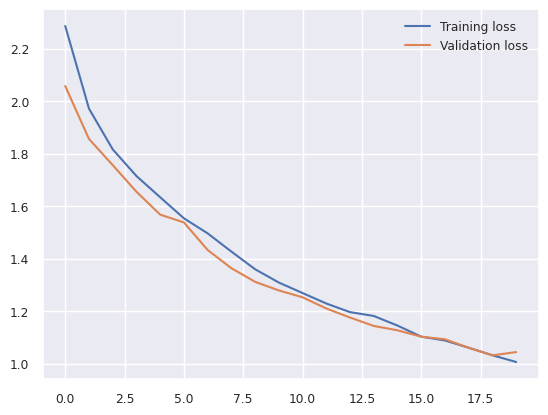

In [143]:
step = 0

#Training loop
train_losses = []
val_losses = []

# Restaurer les poids du modèle et l'état de l'optimiseur
# model.load_state_dict(torch.load("checkpoints/segmentation-epoch-6.pth"))

# Restaurer le numéro de l'époque
#start_epoch = 6 + 1
for epoch in range(train_config['epochs']):
    # Model Training
    model.train()
    step += 1

    pbar = tqdm(train_loader)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])

    for idx, (img, y) in enumerate(pbar):
        # load target
        y = y.to(device)
        # model output
        y_hat = model(img)

        # loss computation
        loss = criterion(y_hat, y)

        # backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get prediction
        _, pred = torch.max(y_hat, dim=1)

        epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
        metrics.add_batch(y, pred)

        pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

    mean_loss = epoch_losses.mean()
    train_losses.append(mean_loss)
    train_stats = {
            "train_loss": mean_loss.item(),
            "train_average_accuracy": metrics.get_average_accuracy(),
            "train_mIoU": metrics.get_mIoU(),
            **{
                "train_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
    print(train_stats)

    # Model Validation
    model.eval()
    pbar = tqdm(val_loader)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])

    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)

            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        val_losses.append(mean_loss)
        val_stats = {
            "validation_loss": mean_loss.item(),
            "validation_average_accuracy": metrics.get_average_accuracy(),
            "validation_mIoU": metrics.get_mIoU(),
            **{
                "validation_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
            "train_IoU_" + k: v
            for k, v in metrics.get_IoU().items()
        },
        }

        print(f"Epoch:{epoch}", val_stats)

        # Save model checkpoint every 2 epochs
        if epoch % 2 == 0:
            if epoch == 0:
                continue

            save_weights_path = (
                "checkpoints/" + "-".join(["segmentation", "epoch", str(epoch)]) + ".pth"
            )
            torch.save(model.state_dict(), save_weights_path)

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

In [144]:
def test(model, test_ld):
    model.eval()
    pbar = tqdm(test_ld)

    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)
            all_gts.append(y.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        test_stats = {
            "test_loss": mean_loss.item(),
            "test_average_accuracy": metrics.get_average_accuracy(),
            "test_mIoU": metrics.get_mIoU(),
            **{
                "test_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
        print("Test stats:")

        # Loss
        print(f"  Loss: {test_stats['test_loss']:.4f}")

        # Average accuracy and mIoU
        print(f"  Average Accuracy: {test_stats['test_average_accuracy']:.4f}")
        print(f"  Mean IoU: {test_stats['test_mIoU']:.4f}")

        # Accuracy per class
        print("  Accuracy by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'test_accuracy_pixelclass_{i}']:.4f}")

        # IoU per class
        print("  IoU by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'train_IoU_class_{i}']:.4f}")
        all_preds = np.concatenate(all_preds)
        all_gts = np.concatenate(all_gts)

        # Calculer la matrice de confusion
        conf_matrix = confusion_matrix(all_gts.flatten(), all_preds.flatten(), labels=np.arange(data_config['num_classes']))
        # Normalisation par lignes
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.set(font_scale=0.8)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(dict_classes_13.values()), yticklabels=list(dict_classes_13.values()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #sns.set(font_scale=1.2)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    return

In [145]:
torch.save(model.state_dict(), '../../drive/MyDrive/MVA/swin-t_SSL_freeze_20.pth')

Validation Loss:1.058: 100%|██████████| 33/33 [00:37<00:00,  1.13s/it]


Test stats:
  Loss: 1.0577
  Average Accuracy: 0.4596
  Mean IoU: 0.3409
  Accuracy by Class:
    Class 0: 0.7907
    Class 1: 0.2208
    Class 2: 0.7236
    Class 3: 0.0112
    Class 4: 0.8289
    Class 5: 0.4557
    Class 6: 0.8298
    Class 7: 0.3801
    Class 8: 0.6870
    Class 9: 0.6502
    Class 10: 0.3933
    Class 11: 0.0027
    Class 12: 0.0000
  IoU by Class:
    Class 0: 0.5897
    Class 1: 0.1720
    Class 2: 0.5764
    Class 3: 0.0112
    Class 4: 0.5860
    Class 5: 0.4000
    Class 6: 0.6692
    Class 7: 0.2622
    Class 8: 0.4590
    Class 9: 0.4575
    Class 10: 0.2458
    Class 11: 0.0024
    Class 12: 0.0000


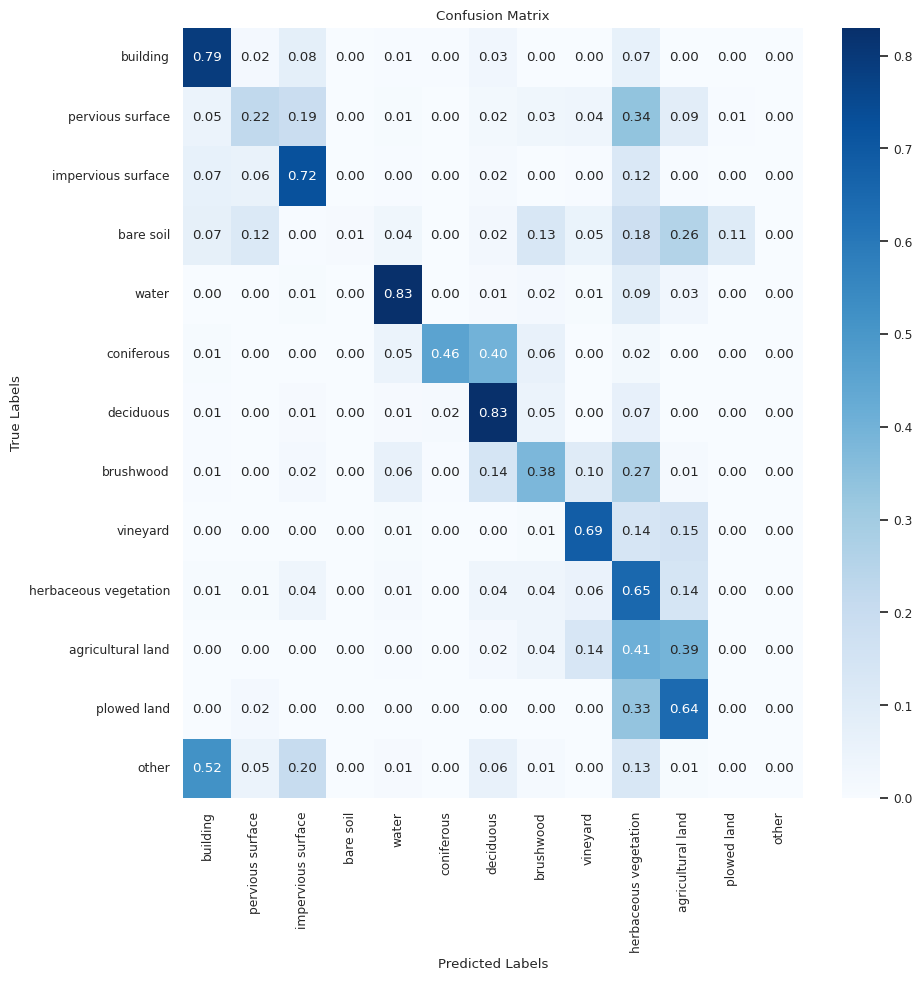

In [146]:
# create a new model's instance
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)

model = model.to(device)

# load checkpoints weights
model.load_state_dict(torch.load("../../drive/MyDrive/MVA/swin-t_SSL_freeze_20.pth"))

test(model, test_loader)